In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import pandas as pd
import requests
import io

# Importing Dataset

In [ ]:
# Downloading the csv files from the GitHub account

url_metabolic = "https://raw.githubusercontent.com/himasai97/ML_Approaches/master/Data/flux.csv"
url_phen = "https://raw.githubusercontent.com/himasai97/ML_Approaches/master/Data/Phenotype_Measurements.csv"


download_metabolic = requests.get(url_metabolic).content
download_phen = requests.get(url_phen).content


# Reading the downloaded content and turning it into a pandas dataframes

metabolic = pd.read_csv(io.StringIO(download_metabolic.decode('utf-8'))) #Input metabolic data of fluxes and metabolites
y = pd.read_csv(io.StringIO(download_phen.decode('utf-8'))) #Output Phenotype values

#Extracting data relevant to phenotypes under study
#because the study is to understand the effect of transgenic modifications on the traits of the plant,
#height, volume and diameter are more relevant to the study than their growth rates. Hence the three rates are being dropped.
y = y.drop(columns=['Row_1', 'HeightRate','DiameterRate', 'VolumeRate']) #removing the label, and the three irrelevant phenotypes

#Extracting data relevant to input flux

l =list(range(1,16))+list(range(17,20))+list(range(22,26))+list(range(27,38))+["12R","14R"];
FluxNames = ["V"+str(num1) for num1 in l]; #35 fluxes
MetNames = ["Y"+str(num2) for num2 in range(2,25)];

flux = metabolic[FluxNames];
X = flux.round(9);

#Getting a list of the Phenotype names
Phen_arr = y.columns;

#Check the size of the data: X-(#samples,#fluxes) and y-(#samples,#phenotypes), where #fluxes=35, #phenotypes=25
print ("X has {} sample points corresponding to the {} fluxes.".format(*X.shape))
print ("y has {} sample points corresponding to the {} phenotypes.".format(*y.shape))


# Preparing Dataset

## Handling NaN Values
Missing values in the phenotype measurements are represented as NaNs. For preprocessing, we remove the rows in the flux data that corresponding to the missing values in phenotype measurements. This function is implemented using a user defined routine: **rem_nan**.

In [ ]:
#For Removing NaN
def rem_nan(X,y,Phen):
    y_i = y[Phen]
    #extacting index positions where y_i has NaN values
    idx = y_i.index[y_i.apply(np.isnan)] #to get the row names
    Nan_idx=[(np.where(y.index==idx[i])[0][0]) for i in range(len(idx))] #to get the row numbers for X_i
    X_i = X.drop(Nan_idx,axis =0)
    y_i = y_i.drop(idx,axis =0)
    return X_i, y_i

## Scaling the Data
Most of the machine learning algorithms are designed with the assumption that all independent features present in the data vary on comparable scales. So, when the input features have very different scales, it can degrade the predictive performance of these algorithms. Unscaled data can also lead to longer times or even prevent convergence for many gradient-based estimators. Thus, scaling the data is an important step in data preprocessing for many ML approaches. Among the many scikit-learn methods available for this purpose, we use **MinMaxScaler** as it preserves the shape of the original distribution.

For each value in an input feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the maximum and minimum values in the feature. The values returned by MinMaxScaler are thus between 0 and 1.

### Implementation
In a typical machine learning workflow, we need to apply the above transformations at least twice. Once when training the model and again on any new data we want to predict on. To automate this workflow, we use Scikit-learn **Pipeline** method, as it sequentially applies the transformer and the estimator on a given dataset. The Pipeline approach is especially useful when applying cross-validation where each set of training data needs to be transformed before being fed into the ML estimator. 


# Hyperparamter Optimization
For a machine learning algorithm, hyperparameters are set before training and supplied to the model. They are different from the model parameters that are learned during training by the machine. Hyperparameters are tuned by the user to achieve optimal model performance. We use **GridSearchCV**, a library function from sklearn’s *model_selection package*. From a given grid of hyperparameter values, defined using the *param-grid* parameter, it exhaustively loops through all combinations to optimize the given model (*estimator*) using cross-validation. The performance of the selected hyper-parameters and the trained model is then measured on a dedicated evaluation set that was not used during the model selection step. The number of folds used in the cross-validation (*cv*) and the metric used for evaluation (*scoring*) are both defined along with the *estimator* and the *param-grid* parameters in the GridSearchCV function.


In [ ]:
# Setting up parameters for the ML approach

# Defining a 10-repeat 5-fold Cross-validation
k_fold = RepeatedKFold(n_splits=5, n_repeats=10)

#Defining model learner for the three ML approaches - learner
l_SVR = SVR(kernel='rbf')
l_XGB = XGBRegressor() 
l_KNN = neighbors.KNeighborsRegressor()

learner = [l_XGB, l_KNN, l_SVR]

# Defining a grid of hyperparameter values for each ML approach - tuned_param
t_SVR = [{'learner__epsilon':[0.05,0.01,0.1,0.001],'learner__gamma': [5,0.1,0.8,50], 'learner__C': [5,80, 1000, 5000]}]

t_XGB = [{"learner__learning_rate"    : [0.05, 0.10, 0.20, 0.30 ] ,
           "learner__max_depth"        : [3,4,5,6,8,12 ],
           "learner__min_child_weight" : [7,5,3,1],
           "learner__gamma"  : [ 0.0,0.1,0.3,0.4  ],
           "learner__colsample_bytree" : [ 0.3,0.4,0.5,0.7 ] }]

t_KNN = [{'learner__n_neighbors': list(range(1, 21)),'learner__weights':['uniform','distance'],'learner__metric':['euclidean','manhattan']}]

tuned_param = [t_XGB, t_KNN, t_SVR]

#Selecting the ML approach to be implemented using its index position in the learner and tuned_param arrays - ml_idx
ml_idx = int(input('Type the integer corresponding to the ML model to be implemented: 0 for XGB, 1 for kNN, 2 for SVR'))

#For Scaling the Data
min_max_scaler = MinMaxScaler()

# Defining the pipeline object with a scaler and a leaner model.
steps = [('scaler', min_max_scaler), ('learner', learner[ml_idx])]
pipeline = Pipeline(steps) 

# Implementation of GridSearch to tune the pipeline method for best score 
# from the given grid of hyper-parameters using cross-validation.
clf = GridSearchCV(estimator=pipeline,
       param_grid= tuned_param[ml_idx], n_jobs=-1, cv=k_fold,scoring ='r2',return_train_score=True)

# Here setting n-jobs as -1 ensures that all available processors are used in the GridSearch implementation 
# and as the name implies, return_train_score is set to True to return the training scores evaluated for the different folds.

In [ ]:
#Initialise arrays for the different metrics
R2 = []
MSE = []
MAE = []

#Implementation
for Phen_idx in range(25):

    Phen = Phen_arr[Phen_idx]

    X_i, y_i = rem_nan(X,y,Phen)
    X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size=0.2, random_state=7)


    clf.fit(X_train,y_train)
    Param = clf.best_estimator_
    train_r2 = clf.best_score_
    
    #Saving the model
    filename = 'model_',Phen,'.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    #To reload the saved model
    loaded_model = pickle.load(open(filename, 'rb'))

    #For final evaluation of the trained model, test data is used
    y_pred = loaded_model.predict(X_test)

    R2[Phen_idx] = r2_score(y_test,y_pred)
    MSE[Phen_idx] = mean_squared_error(y_test, y_pred)
    MAE[Phen_idx] = mean_absolute_error(y_test, y_pred)
    


As an exhaustive searching tool, Grid-searching is computationally expensive and takes quite a long time to run. To tackle this issue, the above code has been implemented on a High Performance Computing (HPC) Cluster that distributes the work across multiple CPUs to reduce the execution time as much as possible.

# Results

The three evaluation metrics for different phenotypes are visualised below. For better analysis of the error metrics, Root Mean Square Error (RMSE) is calculated from Mean Square Error (MSE) as RMSE gives a relatively high weight to large errors. Mean Absolute Error (MAE) and R<sup>2</sup> are the other metrics visualised here.

## Figure 1: R<sup>2</sup> values
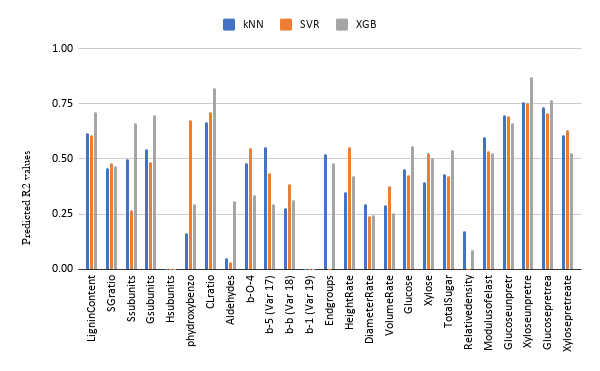

## Figure 2: MAE values
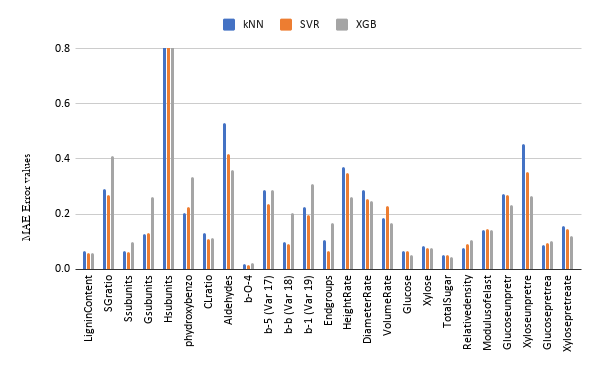

## Figure 3: RMSE values
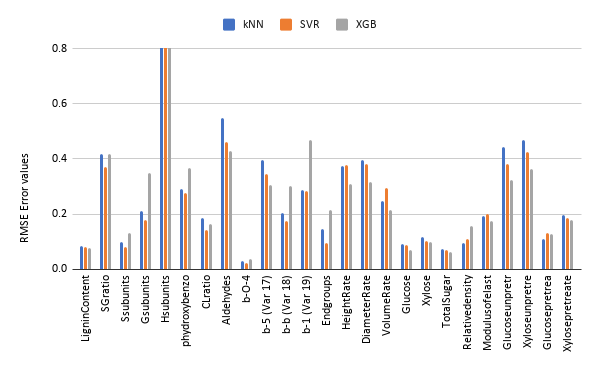
<img src="img/file.png", width=200, height=200>

# Analysis
We observe that Support Vector Regression (SVR) model has a better overall performance with lower errors (MAE, RMSE) and higher $R^2$ values than Gradient Boost(XGB) and k-Nearest Neighbors (kNN) regression approaches, indicating that an SVR approach is better able to explain the lignin and wood traits using the steady-state fluxes as predictors than others. 

For four of the lignin and wood traits, including H subunits, $\beta-1$ linkages, endgroups, and relative density, at least one of the ML regression models has a non-positive $R^2$ value (Fig 1). There are multiple possible explanations for this behavior, including poor fit in general, presence of outliers in the data that are disproportionately skewing the $R^2$ values, or poor partitioning of the data in the cross-validation folds. As there is very little variation in the MAE and RMSE errors for $\beta-1$ linkages, endgroups, and relative density (Fig 2,3), it can be noted that for these traits there could only be a small number of predictions that deviated from the actual values by a large difference.

For nine of the lignin and wood traits, including Lignin Content,S subunits, G subunits, CL ratio, aldehydes, glucose, total sugar, saccharification of xylose in unpretreated samples, and saccharification of glucose in pretreated samples, the predictions from XGB have a significantly higher $R^2$ values, indicating superior performance among the ML models. However, SVR provides a better fit for four phenotype traits, including phydroxybenzoate, $\beta-O-4$ linkages, height, and saccharification of xylose in pretreated samples (Fig 1). 

It should be noted that with the exception of 4 traits having a non-positive $R^2$ value, the ML models captured the variation in 16 of the lignin and wood traits moderately well, with at least one model having an $R^2$ value greater than 0.5, including Lignin content, S subunits, G subunits, phydroxybenzoate, CL ratio, $\beta-O-4$ linkages, $\beta-5$ linkages, height, glucose, xylose, total sugar, modulus of elasticity (MOE), saccharification of glucose in unpretreated samples, saccharification of xylose in unpretreated samples, saccharification of glucose in pretreated samples, and saccharification of xylose in pretreated samples. The remaining 5 traits, including SG ratio, aldehydes, $\beta-\beta$ linkages, diameter, and volume, have $R^2$ value less than 0.5.